# Emotion Detection with Computer Vision

###Overview

This project proposes a Facial Emotion Classifier that compares multiple computer vision methods and experimental setups to determine the best approach. Using the Kaggle Face Expression Recognition dataset, we will implement three main classifier families of increasing complexity: a baseline single-layer network on extracted features, a deep ResNet-style CNN, and a Vision Transformer–based model. For each model, we will explore data augmentation with GANs and systematic hyperparameter tuning with Python tooling, to study their impact on accuracy and generalization. We will plot and analyze our results and display our model's accuracy after each trial to best showcase the findings of our experimentation.

# Defining Standard Architecture

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import copy
from collections import Counter

In [ ]:
# Initialize Data
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")

Using Colab cache for faster access to the 'face-expression-recognition-dataset' dataset.


In [ ]:


data_root = os.path.join(path, "images")
train_dir = os.path.join(data_root, "train")
val_dir = os.path.join(data_root, "validation")

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(12),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.1)),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2)
])

train_set = datasets.ImageFolder(root=train_dir, transform=transform)
test_set = datasets.ImageFolder(root=val_dir, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

print("Classes:", train_set.classes)
print("Train size:", len(train_set))
print("Test size:", len(test_set))

Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Train size: 28821
Test size: 7066


### Computing Inverse Class Weights for Accurate Sampling on Cross-Entropy Loss

In [ ]:
def returnDevice():
  device = None
  if torch.backends.mps.is_available():
      device = torch.device("mps")
      print("Using Apple Silicon GPU (MPS)")
  elif torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using CUDA GPU")
  else:
    device = torch.device("cpu")
    print("Using CPU")
  return device

In [ ]:
# General information about dataset

num_classes = 7

train_labels = np.array(train_set.targets)

class_sizes = np.bincount(train_labels)

total_samples = class_sizes.sum()
class_weights = total_samples / (num_classes * class_sizes)

print("Class Weights:", class_weights)

device = returnDevice()

# calculating weights for imbalanced dataset
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)


Class Weights: [1.0311259  9.44331586 1.00348177 0.57471883 0.8264323  0.83379622
 1.28464453]
Using CPU


### Plotting Model Training Metrics

In [ ]:
def plot_curves(loss, training, test, epochs):
    epochs_axis = range(1, epochs + 1)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].plot(epochs_axis, loss, label='Training Loss')
    axes[0].set_title('Training Loss per Epoch')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(epochs_axis, training, label='Training Accuracy')
    axes[1].set_title('Training Accuracy per Epoch')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].grid(True, alpha=0.3)

    axes[2].plot(epochs_axis, test, label='Test Accuracy')
    axes[2].set_title('Test Accuracy per Epoch')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Accuracy')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

### Image Predictions Simulation

In [ ]:
# Predictions on trained models

mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1) # normalization matrices for images
std  = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)

def imshow(img, ax):
    img = img * std + mean
    img = img.clamp(0, 1)
    npimg = img.permute(1, 2, 0).numpy()
    ax.imshow(npimg)
    ax.axis('off')

def run_predictions(model, dataloader, num_images=5):
  device = next(model.parameters()).device
  num_images = min(num_images, len(test_set))

  indices = np.random.choice(len(test_set), size=num_images, replace=False)

  images_list = []
  labels_list = []

  for idx in indices:
      img, label = test_set[idx]
      images_list.append(img)
      labels_list.append(label)

  images = torch.stack(images_list)
  labels = torch.tensor(labels_list, device=device)

  # Forward pass on the model for predictions
  with torch.no_grad():
      outputs = model(images.to(device))
      _, preds = torch.max(outputs, 1)

  correct = (preds == labels).sum().item()
  accuracy = correct / num_images * 100

  # Plot the figures
  fig, axes = plt.subplots(1, num_images, figsize=(3 * num_images, 3))
  if num_images == 1:
      axes = [axes]

  for i in range(num_images):
      ax = axes[i]
      imshow(images[i], ax)
      pred_label = train_set.classes[preds[i].item()]
      true_label = train_set.classes[labels[i].item()]
      ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}")

  plt.tight_layout()
  plt.show()

  print(f"Correct on this sample: {correct}/{num_images} = {accuracy:.1f}%")

### Testing & Metrics Function

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    log_loss,
    average_precision_score
)
from sklearn.preprocessing import label_binarize

In [ ]:
# Testing Samples and Calculating Model Performance Metrics
def test_model(model, dataloader):
  device = next(model.parameters()).device
  class_names = train_set.classes
  average_type="macro"
  ce_loss_fn = nn.CrossEntropyLoss(reduction="sum")

  all_logits = []
  all_labels = []
  total_loss = 0.0
  total_samples = 0

  with torch.no_grad():
      for images, labels in dataloader:
          images = images.to(device)
          labels = labels.to(device)

          outputs = model(images)
          loss = ce_loss_fn(outputs, labels)

          total_loss += loss.item()
          total_samples += labels.size(0)

          all_logits.append(outputs.cpu())
          all_labels.append(labels.cpu())

  logits = torch.cat(all_logits, dim=0)
  labels = torch.cat(all_labels, dim=0)
  probs = torch.softmax(logits, dim=1).numpy()
  y_true = labels.numpy()
  y_pred = probs.argmax(axis=1)

  num_classes = probs.shape[1]
  if class_names is None:
      class_names = [str(i) for i in range(num_classes)]

  # Accuracy
  acc = accuracy_score(y_true, y_pred)

  # Precision, Recall, F1
  precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=average_type, zero_division=0)

  # Confusion matrix
  cm = confusion_matrix(y_true, y_pred)

  # Log loss (cross entropy)
  logloss_val = log_loss(y_true, probs, labels=list(range(num_classes)))

  # Mean Average Precision
  y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
  map = average_precision_score(y_true_bin, probs, average="macro")
  ce_loss_per_sample = total_loss / total_samples

  print(f"Accuracy: {acc:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1-score:  {f1:.4f}")
  print(f"Log loss: {logloss_val:.4f}")
  print(f"Cross-entropy: {ce_loss_per_sample:.4f}")
  print(f"Mean Average Precision: {map:.4f}")
  print("Confusion matrix:\n", cm)

# Data Augmentation

## GAN Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# GAN hyperparameters
nz = 100
ngf = 64
ndf = 64
nc = 3
image_size = 48
lr_g = 2e-4
lr_d = 2e-4
beta1 = 0.5
num_gan_epochs = 100

# Generator model architecture
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__() # upsampling images
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 3, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Discrimination model architecture
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__() #downsampling
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),   # 24x24
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),  # 12x12
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),  # 6x6
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),  # 3x3
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 3, 1, 0, bias=False),        # 1x1
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1)



In [ ]:
#initialize models and move them to device for optimized training
netG = Generator(nz, ngf, nc).to(device)
netD = Discriminator(nc, ndf).to(device)

criterion_gan = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))


In [ ]:
def train_gan(dataloader, num_epochs=num_gan_epochs):
    netG.train()
    netD.train()

    fixed_noise = torch.randn(64, nz, 1, 1, device=device)

    for epoch in range(num_epochs):
        for i, (real_imgs, _) in enumerate(dataloader):
            real_imgs = real_imgs.to(device)
            b_size = real_imgs.size(0)

            # Real and fake labels
            real_label = torch.ones(b_size, device=device)
            fake_label = torch.zeros(b_size, device=device)


            # 1. Update D: maximize log(D(x)) + log(1 - D(G(z)))
            netD.zero_grad()

            # Real
            output_real = netD(real_imgs)
            lossD_real = criterion_gan(output_real, real_label)

            # Fake
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake_imgs = netG(noise).detach()
            output_fake = netD(fake_imgs)
            lossD_fake = criterion_gan(output_fake, fake_label)

            lossD = lossD_real + lossD_fake
            lossD.backward()
            optimizerD.step()


            # 2. Update G: maximize log(D(G(z)))

            netG.zero_grad()
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake_imgs = netG(noise)
            output_fake_for_G = netD(fake_imgs)
            lossG = criterion_gan(output_fake_for_G, real_label)
            lossG.backward()
            optimizerG.step()

        print(f"Epoch [{epoch+1}/{num_epochs}]  Loss_D: {lossD.item():.4f}  Loss_G: {lossG.item():.4f}")

    #see sample
  #if (epoch + 1) % 10 == 0 or epoch == 0:
    netG.eval()
    with torch.no_grad():
        fake = netG(fixed_noise).cpu()
    grid = torchvision.utils.make_grid(fake, nrow=8, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Generated faces")
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.show()

train_gan(train_loader, num_epochs=30)  # adjust epochs depending on time


Epoch [1/30]  Loss_D: 0.0811  Loss_G: 4.5587
Epoch [2/30]  Loss_D: 0.0891  Loss_G: 4.4077
Epoch [3/30]  Loss_D: 0.1257  Loss_G: 6.2293
Epoch [4/30]  Loss_D: 0.1367  Loss_G: 3.3411
Epoch [5/30]  Loss_D: 0.5791  Loss_G: 5.1580
Epoch [6/30]  Loss_D: 0.0582  Loss_G: 7.9840
Epoch [7/30]  Loss_D: 0.0271  Loss_G: 4.3563
Epoch [8/30]  Loss_D: 0.0620  Loss_G: 5.9262
Epoch [9/30]  Loss_D: 0.0466  Loss_G: 3.7755
Epoch [10/30]  Loss_D: 0.8326  Loss_G: 0.1007
Epoch [11/30]  Loss_D: 0.0394  Loss_G: 5.6782
Epoch [12/30]  Loss_D: 1.5075  Loss_G: 8.0761
Epoch [13/30]  Loss_D: 0.1395  Loss_G: 5.9880
Epoch [14/30]  Loss_D: 0.0379  Loss_G: 5.2183
Epoch [15/30]  Loss_D: 0.1156  Loss_G: 5.6219
Epoch [16/30]  Loss_D: 0.0793  Loss_G: 5.5415
Epoch [17/30]  Loss_D: 0.0671  Loss_G: 4.1508
Epoch [18/30]  Loss_D: 0.0296  Loss_G: 4.6724
Epoch [19/30]  Loss_D: 0.0821  Loss_G: 3.7951
Epoch [20/30]  Loss_D: 0.3141  Loss_G: 1.3397
Epoch [21/30]  Loss_D: 0.0716  Loss_G: 5.8397
Epoch [22/30]  Loss_D: 0.0562  Loss_G: 6.39

## DCGAN

In [ ]:
# Generator Class
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.main(x)


# Discriminator Class
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.main(x).view(-1)


In [ ]:
# Dataset Download

print("Downloading FER dataset...")
path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")

data_root = os.path.join(path, "images/train")  # use train images only
print("Dataset path:", data_root)


# Hyperparameters (DCGAN standard)

image_size = 64
batch_size = 128
nc = 3       # channels
nz = 100     # latent vector
ngf = 64     # generator size
ndf = 64     # discriminator size
num_epochs = 300
lr = 0.0002
beta1 = 0.5


# Data Transformations
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = torchvision.datasets.ImageFolder(root=data_root, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

print("Loaded training images:", len(dataset))

Using Colab cache for faster access to the 'face-expression-recognition-dataset' dataset.
Dataset path: /kaggle/input/face-expression-recognition-dataset/images/train
Loaded training images: 28821


In [ ]:
############################################################
# DCGAN — FULL WORKING CODE + BEST MODEL SAVING LOGIC
############################################################

import os
import random
import numpy as np
import matplotlib.pyplot as plt

import copy
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils

# KaggleHub
import kagglehub


# ============================================================
# 0. SETUP
# ============================================================

manualSeed = 999
print("Random Seed:", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# ============================================================
# 4. WEIGHT INITIALIZATION
# ============================================================

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# ============================================================
# 7. CREATE MODELS
# ============================================================

netG = Generator().to(device)
netG.apply(weights_init)

netD = Discriminator().to(device)
netD.apply(weights_init)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_noise = torch.randn(64, nz, 1, 1, device=device)


# ============================================================
# 8. BEST MODEL SAVING LOGIC
# ============================================================

model_weights = None

# ============================================================
# 9. TRAINING LOOP
# ============================================================

print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i, (real, _) in enumerate(dataloader):

        #############################################
        # 1. Train Discriminator
        #############################################
        netD.zero_grad()

        real = real.to(device)
        b_size = real.size(0)

        real_label = torch.ones(b_size, device=device)
        fake_label = torch.zeros(b_size, device=device)

        output_real = netD(real)
        lossD_real = criterion(output_real, real_label)
        lossD_real.backward()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        output_fake = netD(fake.detach())
        lossD_fake = criterion(output_fake, fake_label)
        lossD_fake.backward()

        lossD = lossD_real + lossD_fake
        optimizerD.step()

        #############################################
        # 2. Train Generator
        #############################################
        netG.zero_grad()
        label_gen = torch.ones(b_size, device=device)

        output_gen = netD(fake)
        lossG = criterion(output_gen, label_gen)
        lossG.backward()
        optimizerG.step()

    print(f"Epoch [{epoch+1}/{num_epochs}]  LossD: {lossD.item():.4f}  LossG: {lossG.item():.4f}")


    if (epoch + 1) % 5 == 0:
        model_weights = copy.deepcopy(netG.state_dict())
        model_save_path = f"dcgan_epochs/epoch_{epoch+1}.pth"
        torch.save(model_weights, model_save_path)
        print(f"New BEST GENERATOR saved at epoch {epoch+1}")

    ############################################################

    # Show generated images every epoch
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()

    grid = vutils.make_grid(fake, padding=2, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    if (epoch + 1) % 5 == 0:
      image_save_path = f"dcgan_images/epoch_{epoch+1}_images.png"
      plt.savefig(image_save_path)
    plt.show()

print("Training completed.")


Random Seed: 999
Using device: cuda
Using Colab cache for faster access to the 'face-expression-recognition-dataset' dataset.
Dataset path: /kaggle/input/face-expression-recognition-dataset/images/train


KeyboardInterrupt: 

## Synthetic Data Augmentation Pipeline

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# loading initial architecture model
resnet18 = models.resnet18(weights=None)

# updating final layer of model (as above)
num_features = resnet18.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 7)
)

# filling in the best weights based off pre-training
resnet18.load_state_dict(torch.load("/content/Best ResNet Weights.pth", map_location=device))
pretrained_optimized_resnet = resnet18.to(device)
pretrained_optimized_resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# adding images for empty class folders
# import shutil

# def add_real_fallback_if_empty(class_idx, class_name, synthetic_root):
#     for path, label in dataset.samples:
#       if label == class_name:
#         dst_path = os.path.join(synthetic_root, f"{class_name}/fallback.png")
#         shutil.copy(path, dst_path)
#         print(f"  No synthetic images for '{class_name}', "
#           f"copied fallback real image: {os.path.basename(path)}")
#         break

In [ ]:
# Actual Generator Logic and Loading into Dataset
netG = Generator().to(device)
netG.load_state_dict(torch.load("/content/epoch_100_BENCHMARK.pth", map_location=device))
netG.eval()
print("Loaded best generator.")

import os
from torchvision.utils import save_image

def generate_images_for_class(
    class_name,
    num_images,
    output_root="generated_data",
    confidence_threshold=0.7,
    max_attempts_per_image=5,  # to avoid infinite loops
):
    class_path = os.path.join(output_root, class_name)
    os.makedirs(class_path, exist_ok=True)

    netG.eval()
    pretrained_optimized_resnet.eval()

    target_idx = dataset.class_to_idx[class_name]

    count = 0
    batch = 64
    attempts = 0

    classifier_normalize = T.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225]
    )

    fake_batch = None

    while count < num_images and attempts < num_images * max_attempts_per_image:
        attempts += 1

        # 1. Generate candidate images
        noise = torch.randn(batch, nz, 1, 1, device=device)
        with torch.no_grad():
            fake_batch = netG(noise)

        # 2. Prepare for classifier: bring to [0,1], then normalize
        imgs_for_cls = (fake_batch * 0.5) + 0.5
        imgs_for_cls = classifier_normalize(imgs_for_cls)

        # 3. Run through classifier
        with torch.no_grad():
            logits = pretrained_optimized_resnet(imgs_for_cls.to(device))
            probs = F.softmax(logits, dim=1)

        # 4. Filter & save only high-confidence images for this class
        for i in range(fake_batch.size(0)):
            if count >= num_images:
                break

            p = probs[i, target_idx].item()
            if p >= confidence_threshold:
                img_tensor = fake_batch[i].cpu()
                img_path = os.path.join(class_path, f"img_{count:05d}.png")

                # Unnormalize for saving
                img_to_save = (img_tensor * 0.5) + 0.5
                save_image(img_to_save, img_path)

                count += 1

    print(
        f"Generated {count}/{num_images} images for class '{class_name}' "
        f"(threshold={confidence_threshold}, attempts={attempts})."
    )

    return count

from collections import Counter

# Count real images
class_counts = Counter([label for _, label in dataset])
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

print("Real dataset class counts:")
for idx, count in class_counts.items():
    print(f"{idx_to_class[idx]} : {count}")

TARGET_SIZE = 4000

for class_idx, real_count in class_counts.items():
    class_name = idx_to_class[class_idx]
    missing = TARGET_SIZE - real_count

    if missing¡ > 0:
        print(f"Generating {missing} synthetic images for {class_name}...")
        num_generated = generate_images_for_class(class_name, missing)
        if num_generated == 0:
           add_real_fallback_if_empty(class_idx, class_name, synthetic_root)
    else:
        print(f"{class_name} already meets target size.")
        synthetic_root = "generated_data"

synthetic_dataset = torchvision.datasets.ImageFolder(
    root=synthetic_root,
    transform=transform
)

synthetic_loader = torch.utils.data.DataLoader(
    synthetic_dataset, batch_size=batch_size, shuffle=True
)

print("Synthetic dataset size:", len(synthetic_dataset))

Loaded best generator.
Real dataset class counts:
angry : 3993
disgust : 436
fear : 4103
happy : 7164
neutral : 4982
sad : 4938
surprise : 3205
Generating 7 synthetic images for angry...
Generated 7/7 images for class 'angry' (threshold=0.7, attempts=1).
Generating 3564 synthetic images for disgust...
Generated 0/3564 images for class 'disgust' (threshold=0.7, attempts=17820).
fear already meets target size.
happy already meets target size.
neutral already meets target size.
sad already meets target size.
Generating 795 synthetic images for surprise...
Generated 795/795 images for class 'surprise' (threshold=0.7, attempts=607).


FileNotFoundError: Found no valid file for the classes disgust. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

In [ ]:
# generating synthetic dataset
synthetic_dataset = torchvision.datasets.ImageFolder(
    root="/content/generated_data",
    transform=transform
)

synthetic_loader = torch.utils.data.DataLoader(
    synthetic_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
from torch.utils.data import ConcatDataset

# concatentating datasets
combine_dataset = ConcatDataset([dataset, synthetic_dataset])
combine_loader = DataLoader(combine_dataset, batch_size=batch_size, shuffle=True)



# Single Layer Network

In [ ]:
class Single_Layer_Net(nn.Module):
    def __init__(self):
        super(Single_Layer_Net, self).__init__()
        self.fc = nn.Linear(3 * 224 * 224, 7)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

net = Single_Layer_Net().to(returnDevice())

Using CUDA GPU


In [ ]:
# Training single-layer classifier

def train_model(net, trainloader, testloader, learning_rate = 0.001, criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)):
    epochs = 30
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    learning_rate_optimizer = optim.lr_scheduler.StepLR(optimizer, step_size=10,gamma=0.1)

    device = next(net.parameters()).device

    train_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        batch = 0

        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)

            if isinstance(criterion, nn.MSELoss):
                targets = F.one_hot(labels, num_classes=10).float()
                loss = criterion(outputs, targets)
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            batch += 1

            _, preds = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (preds == labels).sum().item()

        average_loss = running_loss / batch
        train_acc = correct_train / total_train

        print(f'Epoch: {epoch+1}/{epochs} --- Train Loss: {average_loss} --- Training Accuracy: {train_acc}')

        correct_test = 0
        total_test = 0

        net.eval()

        with torch.no_grad():
            for images, labels in testloader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_acc = correct_test / total_test

        train_losses.append(average_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        learning_rate_optimizer.step()

    plot_curves(train_losses, train_accs, test_accs, epochs)

Epoch: 1/30 --- Train Loss: 42.388145900354154 --- Training Accuracy: 0.16283265674334688
Epoch: 2/30 --- Train Loss: 41.96602508815588 --- Training Accuracy: 0.16831477047985843
Epoch: 3/30 --- Train Loss: 42.63514123311857 --- Training Accuracy: 0.16623295513687936
Epoch: 4/30 --- Train Loss: 43.39456820435112 --- Training Accuracy: 0.16279795982096387
Epoch: 5/30 --- Train Loss: 43.5335857323691 --- Training Accuracy: 0.16262447520904896
Epoch: 6/30 --- Train Loss: 42.949640527797115 --- Training Accuracy: 0.16699628742930503
Epoch: 7/30 --- Train Loss: 41.8085173249509 --- Training Accuracy: 0.1645675028624961
Epoch: 8/30 --- Train Loss: 42.803141240798716 --- Training Accuracy: 0.16765552895458172
Epoch: 9/30 --- Train Loss: 45.11492863251206 --- Training Accuracy: 0.16893931508275217
Epoch: 10/30 --- Train Loss: 42.907069610122036 --- Training Accuracy: 0.16699628742930503
Epoch: 11/30 --- Train Loss: 13.213675751654378 --- Training Accuracy: 0.1803199056243711
Epoch: 12/30 --- T

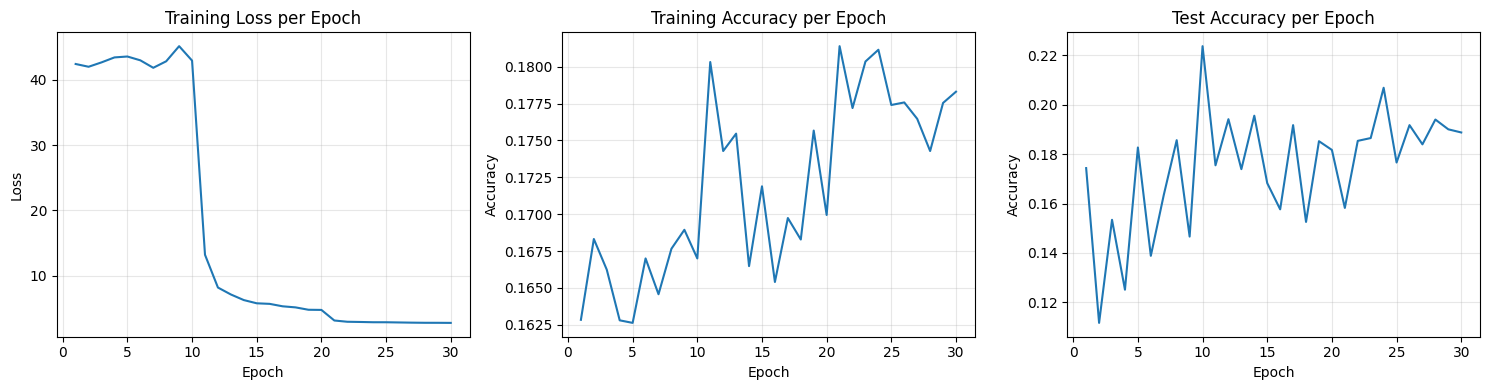

In [ ]:
train_model(net, train_loader, test_loader)

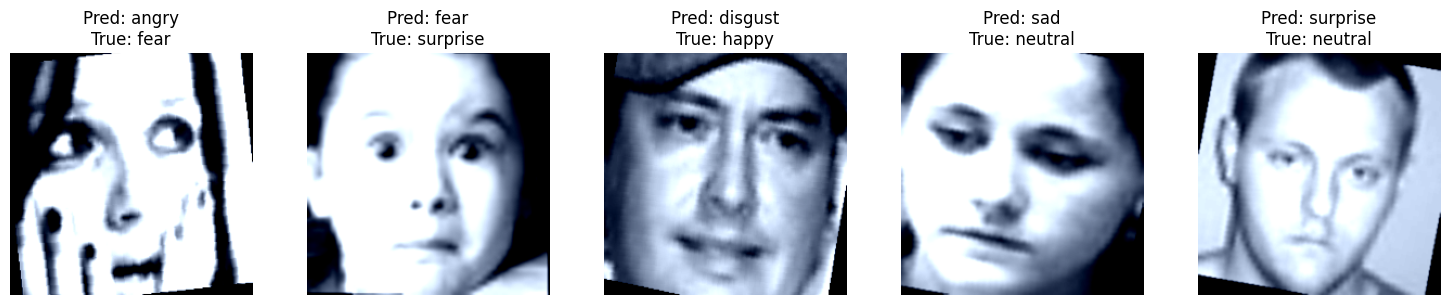

Correct on this sample: 0/5 = 0.0%


In [ ]:
run_predictions(net, test_loader, num_images=5)

In [ ]:
test_model(net, test_loader)

Accuracy: 0.1930
Precision: 0.2146
Recall: 0.2030
F1-score:  0.1860
Log loss: 2.4150
Cross-entropy: 2.4150
Mean Average Precision: 0.1905
Confusion matrix:
 [[126 242 131 106 102 122 131]
 [ 10  28  13  14   9  18  19]
 [ 99 248 155  97 126 134 159]
 [187 453 209 382 187 217 190]
 [123 288 163 120 195 178 149]
 [129 268 154 110 122 224 132]
 [ 63 163 110  49  81  77 254]]


### Findings
Both training and testing accuracy were pretty low when using a single layer network. Training accuracy peaked around 27% while testing accuracy fluctuated between about 18% and 28%. Overall, this model was okay at best as seen by the example predictions. The model usually predicted about 2 of the images correctly in a set of 5, sometimes hitting 3 and going down to 1 or 0. This result is okay but makes sense given the simplicity of the architecture.

# ResNet

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, input_channels, output_channels, stride=1):
    super(ResidualBlock, self).__init__()
    # 2 convolutional layers in each residual block
    self.conv1 = nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(output_channels)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(output_channels, output_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(output_channels)
    # setting up skip/shortcut layer
    self.shortcut = nn.Sequential()
    if stride != 1 or input_channels != output_channels:
      self.shortcut = nn.Sequential(nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride, bias=False))

  def forward(self, x):
    # x here is input tensor
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out = out + self.shortcut(x)
    out = self.relu(out)
    return out

In [ ]:
class ResNet18(nn.Module):
  def __init__(self, num_classes=10):
    super(ResNet18, self).__init__()
    self.input_channels = 64
    self.conv_1_x = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.conv_2_x = self.make_layer(ResidualBlock, 64, 2, 1)
    self.conv_3_x = self.make_layer(ResidualBlock, 128, 2, 2)
    self.conv_4_x = self.make_layer(ResidualBlock, 256, 2, 2)
    self.conv_5_x = self.make_layer(ResidualBlock, 512, 2, 2)
    self.bn_1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU(inplace=True)
    self.average_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc_layer = nn.Linear(512, num_classes)

  def make_layer(self, block, output_channels, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []
    for stride in strides:
      layers.append(block(self.input_channels, output_channels, stride))
      self.input_channels = output_channels
    return nn.Sequential(*layers)

  def forward(self, x):
    out = self.conv_1_x(x)
    out = self.bn_1(out)
    out = self.relu(out)
    # going through residual blocks of convolutional layers
    out = self.conv_2_x(out)
    out = self.conv_3_x(out)
    out = self.conv_4_x(out)
    out = self.conv_5_x(out)
    # average pooling layer for image condensation
    out = self.average_pool(out)
    out = out.view(out.size(0), -1)
    # fully connected layer to get ouputs
    out = self.fc_layer(out)
    return out

model = ResNet18(7)

In [ ]:
def train_resnet_model(net, trainloader, testloader, learning_rate = 0.001, criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)):
    if torch.backends.mps.is_available():
      device = torch.device("mps")
      print("Using Apple Silicon GPU (MPS)")
    elif torch.cuda.is_available():
      device = torch.device("cuda:0")
      print("Using CUDA GPU")
    else:
      device = torch.device("cpu")
      print("Using CPU")

    net.to(device)

    epochs = 30
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    train_losses = []
    train_accs = []
    test_accs = []

    best_acc = 0.0
    best_model_wts = copy.deepcopy(net.state_dict())
    save_path = "best_resnet_weights_synthetic_model.pth"

    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        net.train()

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.to(device))

            if isinstance(criterion, nn.MSELoss):
                targets = F.one_hot(labels, num_classes=10).float().to(device)
                loss = criterion(outputs, targets.to(device))
            else:
                loss = criterion(outputs, labels.to(device))

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (preds == labels).sum().item()

        average_loss = running_loss / len(trainloader)
        train_acc = correct_train / total_train

        correct_test = 0
        total_test = 0

        net.eval()

        with torch.no_grad():
            for images, labels in testloader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_acc = correct_test / total_test

        train_losses.append(average_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f'Epoch: {epoch+1}/{epochs} --- Train Loss: {average_loss} --- Training Accuracy: {train_acc} --- Testing Accuracy: {test_acc}')

        if test_acc > best_acc:
            best_acc = test_acc
            best_model_wts = copy.deepcopy(net.state_dict())
            torch.save(best_model_wts, save_path)
            print(f"New best model saved at epoch {epoch+1} with test acc = {best_acc:.4f}")

    plot_curves(train_losses, train_accs, test_accs, epochs)

    return net

In [ ]:
train_resnet_model(model, train_loader, test_loader)

# Pre-Trained ResNet

In [ ]:
device = returnDevice()

Using CUDA GPU


In [ ]:
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn

# getting pretrained version of the model
weights = ResNet18_Weights.IMAGENET1K_V1
pretrained_resnet_model = resnet18(weights=weights)

# editing layer learning rates (variant to allow slow and steady changes to performance but heavy training on final layer)
params = [
    {'params': pretrained_resnet_model.layer3.parameters(), 'lr': 1e-4},
    {'params': pretrained_resnet_model.layer4.parameters(), 'lr': 1e-4},
    {'params': pretrained_resnet_model.fc.parameters(), 'lr': 1e-3}
]

optimizer = torch.optim.Adam(params)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=60)

# freeze initial feature extraction weights (already well-trained)
for name, param in pretrained_resnet_model.named_parameters():
  if "layer3" in name or "layer4" in name or "fc" in name:
    param.requires_grad = True
  else:
    param.requires_grad = False

num_features = pretrained_resnet_model.fc.in_features
pretrained_resnet_model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 7)
) # edit the layer to update with our classes

pretrained_resnet_model = pretrained_resnet_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 219MB/s]


Using CUDA GPU
Epoch: 1/30 --- Train Loss: 2.1438911351664314 --- Training Accuracy: 0.07729175104630755 --- Testing Accuracy: 0.017831870931219927
New best model saved at epoch 1 with test acc = 0.0178
Epoch: 2/30 --- Train Loss: 1.8995042212050537 --- Training Accuracy: 0.20862022411232617 --- Testing Accuracy: 0.04174922162468157
New best model saved at epoch 2 with test acc = 0.0417
Epoch: 3/30 --- Train Loss: 1.7499437131758393 --- Training Accuracy: 0.37366680167409205 --- Testing Accuracy: 0.1669968864987263
New best model saved at epoch 3 with test acc = 0.1670
Epoch: 4/30 --- Train Loss: 1.6334686875343323 --- Training Accuracy: 0.462974213581747 --- Testing Accuracy: 0.17180866119445232
New best model saved at epoch 4 with test acc = 0.1718
Epoch: 5/30 --- Train Loss: 1.5416373343303287 --- Training Accuracy: 0.5248751181314972 --- Testing Accuracy: 0.17237475233512595
New best model saved at epoch 5 with test acc = 0.1724
Epoch: 6/30 --- Train Loss: 1.4577055486111805 --- Tr

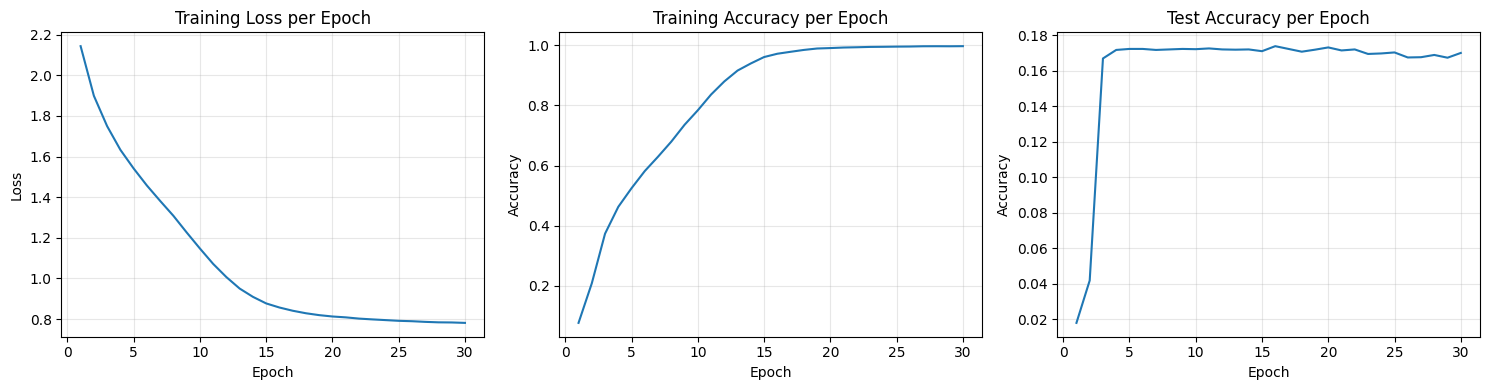

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
train_resnet_model(pretrained_resnet_model, combine_loader, test_loader)

### Testing ResNet Performance (Pre-trained with Transfer Learning)

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving Best ResNet Weights.pth to Best ResNet Weights.pth


In [ ]:
# Import Models

from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.IMAGENET1K_V1
model = resnet18(weights=weights)

model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 7)
)

state_dict = torch.load("Best ResNet Weights.pth", map_location=device)
model.load_state_dict(state_dict)

model.to(device)
print("Loaded model, ready for testing...")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]


Loaded model, ready for testing...


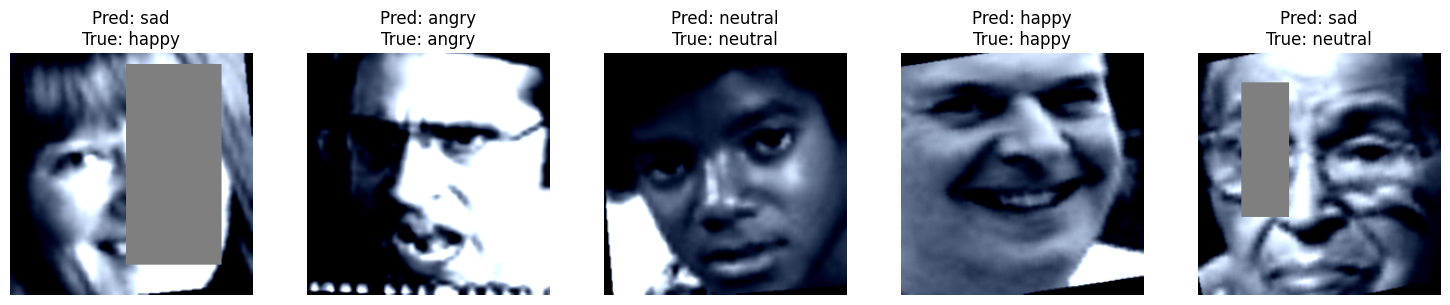

Correct on this sample: 3/5 = 60.0%


In [ ]:
run_predictions(model, test_loader, num_images=5)

In [ ]:
test_model(model, test_loader)

Accuracy: 0.2228
Precision: 0.1989
Recall: 0.1846
F1-score:  0.1873
Log loss: 3.2978
Cross-entropy: 3.2991
Mean Average Precision: 0.1714
Confusion matrix:
 [[193  10 142 154 233 162  66]
 [ 17   3  14  20  24  21  12]
 [152   1 187 152 224 194 108]
 [196   7 269 587 301 333 132]
 [148   1 212 231 278 259  87]
 [186   5 206 216 260 209  57]
 [ 83   4 154 144 151 144 117]]


## Testing ResNet trained with Data Augmentation (GAN)

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving Best ResNet Weights Model.pth to Best ResNet Weights Model.pth


In [ ]:
# Import Models

from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.IMAGENET1K_V1
model = resnet18(weights=weights)

model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 7)
)

state_dict = torch.load("Best ResNet Weights Model.pth", map_location=device)
model.load_state_dict(state_dict)

model.to(device)
print("Loaded model, ready for testing...")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 116MB/s]


Loaded model, read¡¡y for testing...


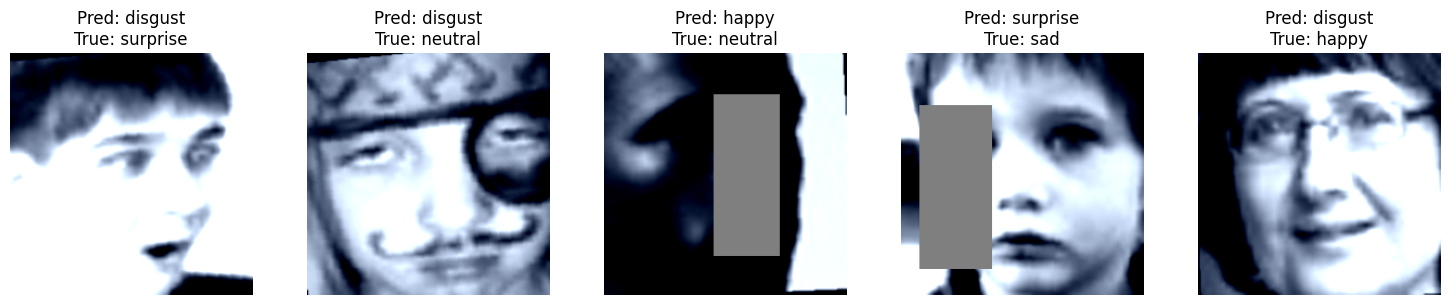

Correct on this sample: 0/5 = 0.0%


In [ ]:
run_predictions(model, test_loader, num_images=5)

In [ ]:
test_model(model, test_loader)

Accuracy: 0.1353
Precision: 0.1446
Recall: 0.1477
F1-score:  0.1290
Log loss: 2.2378
Cross-entropy: 2.2378
Mean Average Precision: 0.1464
Confusion matrix:
 [[125 191 148 146 132 105 113]
 [ 15  27  14  17  19  13   6]
 [123 234 139 134 134 133 121]
 [239 413 261 266 246 191 209]
 [165 265 161 165 171 146 143]
 [144 245 154 168 163 128 137]
 [ 97 171 106 130 109  84 100]]
